In [45]:
import json
import requests
import datetime as dt
import numpy as np
import pandas as pd
from binance.client import Client
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Getting data for last year with 30 min interval

In [46]:
api_key='hKmlFuyZiyNlaN6ARvCKnhF5owS6yrVJolMeSBfThE5Hc6L26aRM2Z3N8EuVQf0y'
secret_key='B4c5Cr9vwsubR19XK05axHk6aSGhnP91GdXLY57LlaYoUNMf4s5egKIHhtgfJYAd'

client = Client(api_key, secret_key)

df= pd.DataFrame(client.get_historical_klines('BTCUSDT','30m',
                                              str((dt.datetime.now() - dt.timedelta(weeks=52))),
                                              str((dt.datetime.now()))))

df.columns=['open_time','open','high','low','close','volume',
           'close_time','q_vol','trades','taker_buy_volume',
            'taker_q_volume','ignored']

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['open_time'], unit='ms')

df = df.set_index('open_time')

df['const'] = np.ones(len(df))

df['trend'] = np.arange(len(df))
df['time'] = df.index 
df=df.drop('close_time',axis=1)
df=df.astype(np.float32,errors='ignore')
df

,open,high,low,close,volume,q_vol,trades,taker_buy_volume,taker_q_volume,ignored,const,trend,time
open_time,,,,,,,,,,,,,
2022-07-19 23:00:00,23498.349609,23630.000000,23303.730469,23346.080078,3503.346680,82218168.0,103017.0,1715.546143,40263168.0,0.0,1.0,0.0,2022-07-19 23:00:00
2022-07-19 23:30:00,23344.130859,23420.710938,23227.849609,23396.619141,2923.406250,68202096.0,85803.0,1398.675415,32633178.0,0.0,1.0,1.0,2022-07-19 23:30:00
2022-07-20 00:00:00,23398.480469,23439.380859,23179.449219,23329.470703,6373.217285,148399232.0,125454.0,3544.198730,82509504.0,0.0,1.0,2.0,2022-07-20 00:00:00
2022-07-20 00:30:00,23329.470703,23356.980469,22922.000000,23034.490234,6796.829590,157014464.0,149993.0,3098.957764,71578440.0,0.0,1.0,3.0,2022-07-20 00:30:00
2022-07-20 01:00:00,23034.490234,23191.349609,22931.419922,23168.810547,4551.768555,105011664.0,109209.0,2161.252686,49877600.0,0.0,1.0,4.0,2022-07-20 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18 17:30:00,29722.000000,29829.419922,29700.220703,29821.769531,763.560974,22730734.0,17778.0,436.388763,12993487.0,0.0,1.0,17459.0,2023-07-18 17:30:00
2023-07-18 18:00:00,29821.759766,29923.550781,29791.429688,29923.539062,714.130432,21319410.0,17846.0,410.706909,12261557.0,0.0,1.0,17460.0,2023-07-18 18:00:00
2023-07-18 18:30:00,29923.550781,29924.759766,29837.179688,29904.980469,526.292664,15726259.0,11902.0,224.832291,6718587.0,0.0,1.0,17461.0,2023-07-18 18:30:00


# Bitcoin price plot

<Axes: xlabel='time', ylabel='open'>

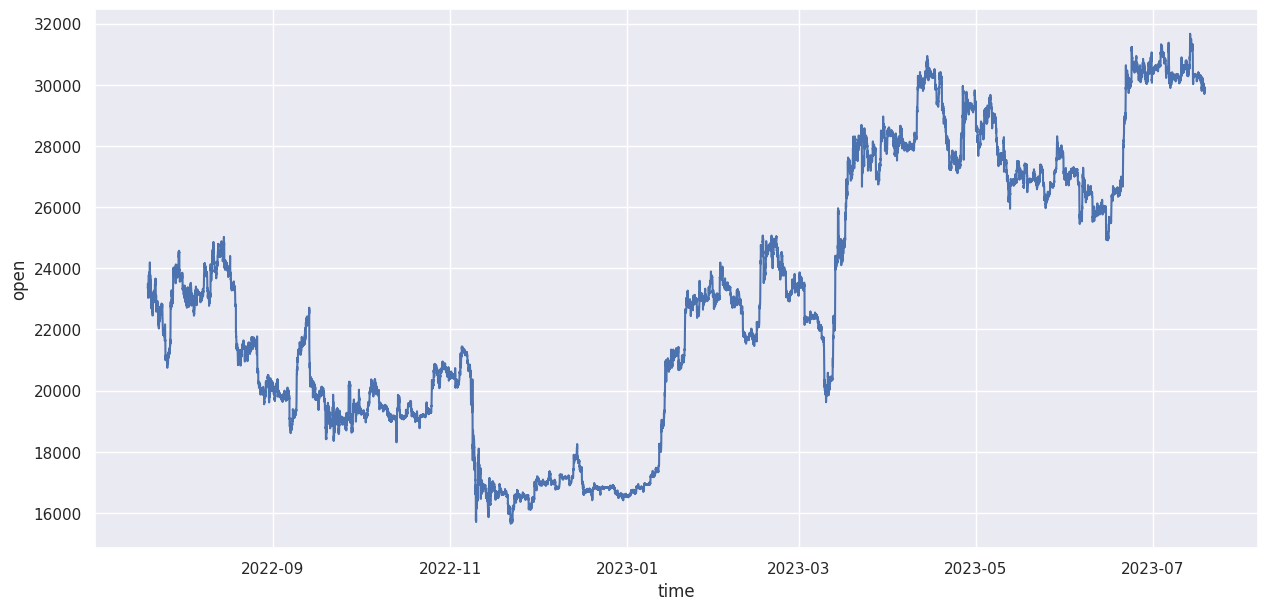

In [47]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df,x='time',y='open')

# Correlation between trades and open price

<Axes: xlabel='open', ylabel='trades'>

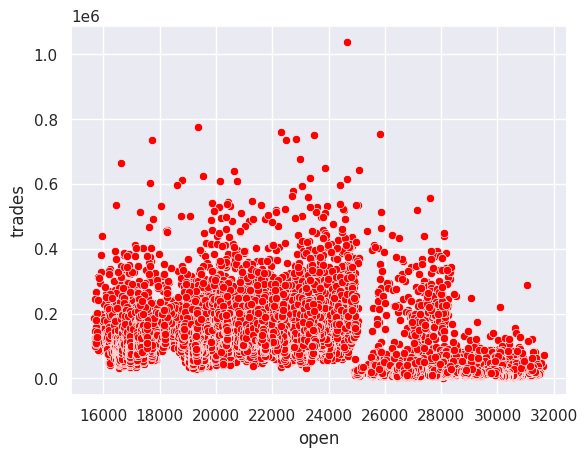

In [49]:
sns.scatterplot(data=df, x='open',y='trades',c='red')

# CREATING TIME TREND FEATURE

In [50]:
df['trend_2']=df.trend**2
df['trend_3']=df.trend**3
df['trend_4']=df.trend**4
X_time_trend=df[['trend','trend_2','trend_3','trend_4']]
y=df['open']

In [51]:
y_dummy = np.ones(len(y))*y.mean()

In [52]:
def check_model_full(model, X, y):
    model.fit(X, y)
    y_pred_1 = model.predict(X)
    print(f'r2 {r2_score(y,y_pred_1)}, absolute {mean_absolute_error(y,y_pred_1)}')
    sns.lineplot(data=df,x='time',y='open')
    sns.lineplot(x=df.time,y=y_pred_1,c='red')
    return y_pred_1

/home/kilka/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e+10, tolerance: 3.456e+07
  model = cd_fast.enet_coordinate_descent(


r2 0.8288052995209372, absolute 1578.859130859375


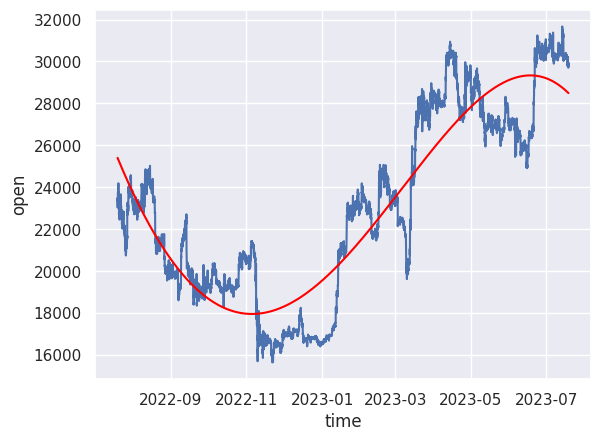

In [53]:
linear = check_model_full(Lasso(max_iter=1000), X_time_trend, y)

r2 0.9791792904302542, absolute 465.1854248046875


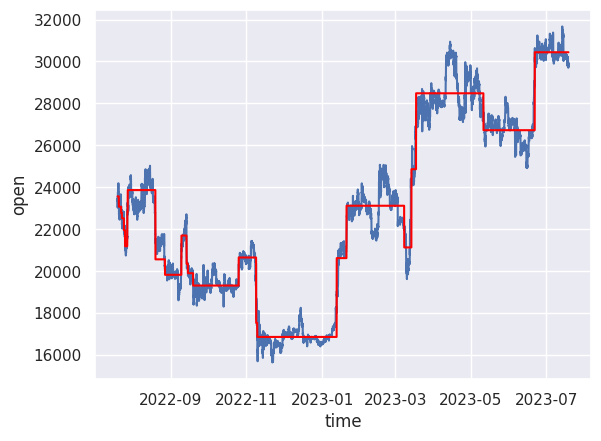

In [54]:
tree = check_model_full(XGBRegressor(n_estimators=2, max_depth=4, learning_rate=1), X_time_trend, y)

# CREATE MOVING AVERAGE

In [77]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()
    rolling_variance = series.rolling(window=window).std()
    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return rolling_mean, rolling_variance

# weekly average 

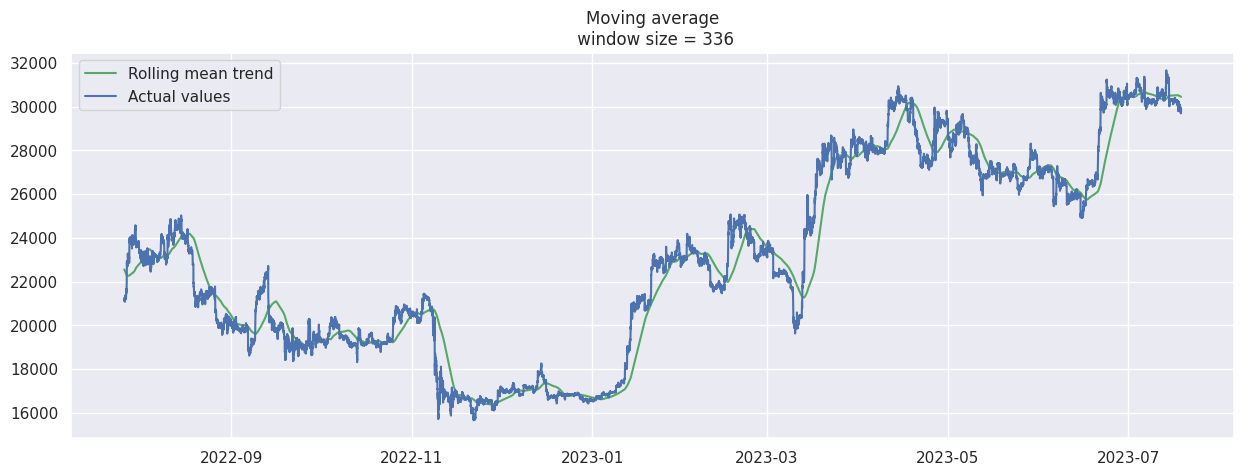

In [85]:
days=7
mov_av_w, mov_var_w = plotMovingAverage(y,int(48*days))

In [86]:
print(f'r2 {r2_score(y[int(48*days):],mov_av_w[int(48*days):])}, '
      f'absolute {mean_absolute_error(y[int(48*days):],mov_av_w[int(48*days):])}')

r2 0.9548465261683478, absolute 653.7611545318307


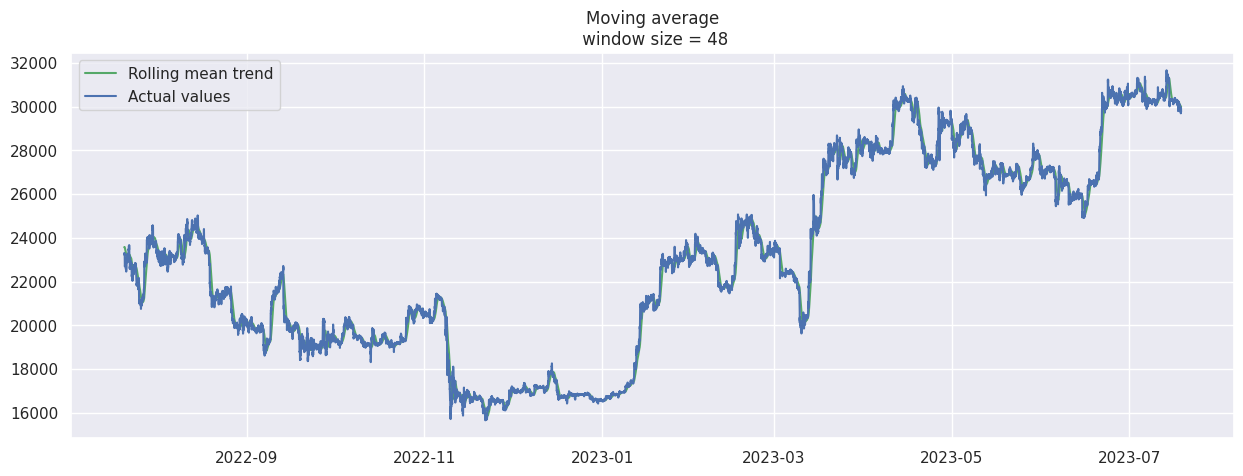

In [87]:
days=1
mov_av_d, mov_var_d = plotMovingAverage(y,int(48*days))

In [88]:
print(f'r2 {r2_score(y[int(48*days):],mov_av_d[int(48*days):])}, '
      f'absolute {mean_absolute_error(y[int(48*days):],mov_av_d[int(48*days):])}')

r2 0.9942656988050107, absolute 220.16569244053005


In [100]:
X=X_time_trend.copy()
X['trades'] = df['trades']
X['linear_trend'] = linear
X['tree_trend'] = tree
X['moving_average_weekly'] = mov_av_w
X['moving_average_daily'] = mov_av_d
X['moving_variance_weekly'] = mov_var_w
X['moving_variance_daily'] = mov_var_d
X['time'] = df.time

In [90]:
X.tail(5)

,trend,trend_2,trend_3,trend_4,trades,linear_trend,tree_trend,moving_average_weekly,moving_average_daily,moving_variance_weekly,moving_variance_daily
open_time,,,,,,,,,,,
2023-07-18 17:30:00,17459.0,304816672.0,5.321794e+12,9.291321e+16,17778.0,28497.269531,30439.910156,30461.380005,30001.394979,403.286406,133.081797
2023-07-18 18:00:00,17460.0,304851584.0,5.322709e+12,9.293449e+16,17846.0,28496.064453,30439.910156,30459.136463,29997.042684,404.743345,135.498174
2023-07-18 18:30:00,17461.0,304886528.0,5.323623e+12,9.295579e+16,11902.0,28494.865234,30439.910156,30457.450573,29994.945190,405.792748,135.847161
2023-07-18 19:00:00,17462.0,304921440.0,5.324538e+12,9.297709e+16,17210.0,28493.658203,30439.910156,30455.739176,29997.082682,406.908358,133.540377
2023-07-18 19:30:00,17463.0,304956384.0,5.325453e+12,9.299839e+16,16013.0,28492.458984,30439.910156,30453.397897,29994.052490,408.570265,136.976285


In [91]:
y

open_time
2022-07-19 23:00:00    23498.349609
2022-07-19 23:30:00    23344.130859
2022-07-20 00:00:00    23398.480469
2022-07-20 00:30:00    23329.470703
2022-07-20 01:00:00    23034.490234
                           ...     
2023-07-18 17:30:00    29722.000000
2023-07-18 18:00:00    29821.759766
2023-07-18 18:30:00    29923.550781
2023-07-18 19:00:00    29904.980469
2023-07-18 19:30:00    29772.669922
Name: open, Length: 17464, dtype: float32

# Seasonal features

In [92]:
def fourier_features(X, freq, order=4):
    X_copy = X.copy()
    time = X.trend
    k =  2 * np.pi * (1 / freq) * time
    for i in range(1, order+1):
        X_copy[f'sin_{i}'] = np.sin(i*k)
        X_copy[f'cos_{i}'] = np.cos(i*k)
    return X_copy

In [93]:
X_fourier = fourier_features(X_time_trend, 365.25*48).drop(['trend','trend_2','trend_3','trend_4'],axis=1)

<Axes: xlabel='open_time'>

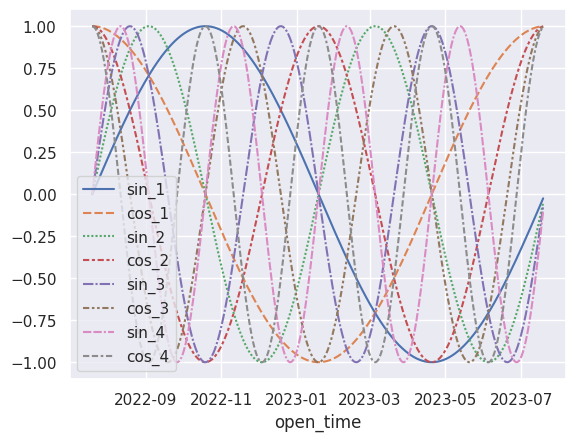

In [94]:
sns.lineplot(data=X_fourier)

In [95]:
X_fourier

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4
open_time,,,,,,,,
2022-07-19 23:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2022-07-19 23:30:00,0.000358,1.000000,0.000717,1.000000,0.001075,0.999999,0.001434,0.999999
2022-07-20 00:00:00,0.000717,1.000000,0.001434,0.999999,0.002150,0.999998,0.002867,0.999996
2022-07-20 00:30:00,0.001075,0.999999,0.002150,0.999998,0.003225,0.999995,0.004301,0.999991
2022-07-20 01:00:00,0.001434,0.999999,0.002867,0.999996,0.004301,0.999991,0.005734,0.999984
...,...,...,...,...,...,...,...,...
2023-07-18 17:30:00,-0.026159,0.999658,-0.052300,0.998631,-0.078405,0.996922,-0.104457,0.994529
2023-07-18 18:00:00,-0.025801,0.999667,-0.051584,0.998669,-0.077332,0.997005,-0.103030,0.994678
2023-07-18 18:30:00,-0.025443,0.999676,-0.050869,0.998705,-0.076262,0.997088,-0.101606,0.994825


r2 0.8860456719577722, absolute 1174.66015625


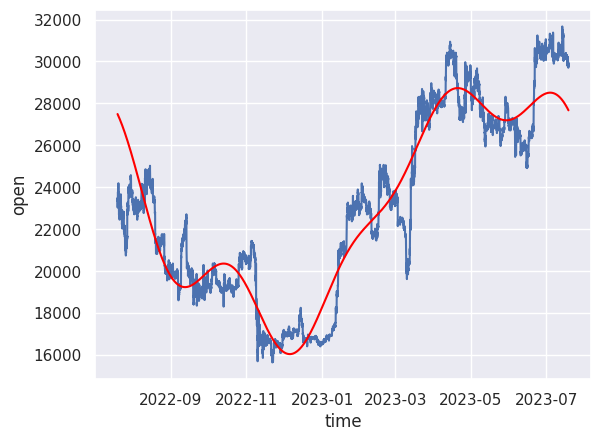

In [96]:
seasonal = check_model_full(Lasso(),X_fourier,y)

In [97]:
X['seasonal'] = seasonal

In [103]:
X.dtypes

trend                            float32
trend_2                          float32
trend_3                          float32
trend_4                          float32
trades                           float32
linear_trend                     float32
tree_trend                       float32
moving_average_weekly            float64
moving_average_daily             float64
moving_variance_weekly           float64
moving_variance_daily            float64
time                      datetime64[ns]
dtype: object

# day of week, day of month, hour of day

In [109]:
dayofmonth = pd.Series(map(lambda x: x.date().day, X.time), index=X.index)

open_time
2022-07-19 23:00:00    19
2022-07-19 23:30:00    19
2022-07-20 00:00:00    20
2022-07-20 00:30:00    20
2022-07-20 01:00:00    20
                       ..
2023-07-18 17:30:00    18
2023-07-18 18:00:00    18
2023-07-18 18:30:00    18
2023-07-18 19:00:00    18
2023-07-18 19:30:00    18
Length: 17464, dtype: int64